This project aims to model whether or not particle physics collisions created a Higgs boson. This data set was already used in another project on machine learning.

This Notebook is for pedagogical purposes only, we do not aim at improving performances compared to traditional ML alogrithms from the other project, we just want to get familiar with the main concepts of neural networks and how to implement them using Pytorch.

The dataset can be found at the following link: https://huggingface.co/datasets/mstz/higgs

Exploratory data analysis and preprocessing have been carried out in detail in the other project with machine learning models using the same data set, we will therefore focus on constructing and training the model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from tqdm import tqdm

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {device}")

Device: cuda


# Preprocessing

In [ ]:
df = pd.read_csv('higgs.csv')
print(df.shape)
print(df.columns)

(98050, 29)
Index(['is_boson', 'lepton_pT', 'lepton_eta', 'lepton_phi',
       'missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta',
       'jet1phi', 'jet1b-tag', 'jet2pt', 'jet2eta', 'jet2phi', 'jet2b-tag',
       'jet3pt', 'jet3eta', 'jet3phi', 'jet3b-tag', 'jet4pt', 'jet4eta',
       'jet4phi', 'jet4b-tag', 'm_jj', 'm_jjj', 'm_lv', ' m_jlv', 'm_bb',
       'm_wbb', 'm_wwbb'],
      dtype='object')


<ipython-input-5-7798cbab3b22>:1: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('higgs.csv')


In [ ]:
for column in ['jet4phi', 'jet4b-tag', 'm_jj', 'm_jjj', 'm_lv', ' m_jlv', 'm_bb', 'm_wbb', 'm_wwbb']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df.dropna(inplace=True)

len(df)

98049

In [ ]:
target_name = 'is_boson'

features = df.sample(frac=1, random_state=42)
target = features.pop(target_name)

columns = features.columns
n_features = len(columns)
print(f"Number of features: {n_features}")

features = np.array(features.values)
target = np.array(target)

features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.2, random_state=42)

target_train = target_train.reshape(-1, 1)
target_val = target_val.reshape(-1, 1)

features_train.shape, target_train.shape, features_val.shape, target_val.shape

Number of features: 28


((78439, 28), (78439, 1), (19610, 28), (19610, 1))

In [ ]:
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(features_train)
X_val = feature_scaler.transform(features_val)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(target_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(target_val, dtype=torch.float32)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([78439, 28]),
 torch.Size([78439, 1]),
 torch.Size([19610, 28]),
 torch.Size([19610, 1]))

# Early stopping

Early stopping will stop the training if the loss didn't decrease for a given number of steps (called "patience").

PyTorch doesn't have a class to do it directly, so we can build our own based on available templates online.

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < (self.min_validation_loss - self.min_delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

We'll have 2 exit conditions:
- if we reach the end of the training (as usual)
- if the early stopping is triggered

So we'll need to compute roc_auc in two places in the code. To avoid repeating the same code two times, we'll create a function to compute this metric.


In [ ]:
def get_roc_auc(model, X_train, X_val, y_train, y_val):
    with torch.no_grad():
        train_pred = model(X_train).detach().cpu().numpy()
        val_pred = model(X_val).detach().cpu().numpy()

        roc_auc_train = roc_auc_score(y_train.detach().cpu().numpy(), train_pred)
        roc_auc_val = roc_auc_score(y_val.detach().cpu().numpy(), val_pred)
        return roc_auc_train, roc_auc_val

We create a function that implements a learning rate scheduler based on cosine annealing



In [ ]:
def lr_schedule_cosine_annealing(i, min_lr, max_lr, num_steps_total, num_steps_warmup=0):
    if i < num_steps_warmup:
        return i * (max_lr - min_lr)/num_steps_warmup + min_lr
    elif i > num_steps_total:
        return min_lr
    else:
        i = i - num_steps_warmup
        num_steps_total = num_steps_total - num_steps_warmup
        lr =  min_lr + (max_lr - min_lr) * (1 + np.cos(i / num_steps_total * np.pi)) / 2
        return max(lr, min_lr)

We also create the function show_history() which visualizes the learning curve of a neural network during training by plotting the training and validation loss over the number of epochs.

In [ ]:
def show_history(history, history_val, num_epochs):
    val_epoch_start = 1 if len(history_val) == num_epochs else 0
    x_axis_train = np.linspace(0, num_epochs, len(history))
    x_axis_val = np.linspace(val_epoch_start, num_epochs, len(history_val))

    plt.plot(x_axis_train, history, label='Training loss')
    plt.plot(x_axis_val, history_val, label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Deep Neural Network

We now create our Deep neural network model. In order to build it we first build a class for a single layer which will serve as a building block for the network itself. Our single layer has a normalization, and a dropout after the fully connected layer for regularization purposes.

In [ ]:
class MLPLayer(nn.Module):
    def __init__(self, input_size, output_size, dropout=0):
        super().__init__()
        self.layer = nn.Sequential(
            nn.LayerNorm(input_size),
            nn.Linear(input_size, output_size),
            nn.Dropout(dropout),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layer(x)


class DeepMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers, dropout=0):
        super().__init__()
        assert num_hidden_layers >= 1, "Need at least one hidden layer"

        hidden_layers = [
            MLPLayer(input_size if i == 0 else hidden_size, hidden_size,dropout) for i in range(num_hidden_layers)
        ]
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

We define a training function with a learning rate scheduler and trial pruning. The role of the learning rate scheduler is to adapt the size of the learning rate depending on a specific schedule during the run. The code uses Optuna's trial pruning mechanism to stop training early if the intermediate validation loss suggests that the trial is not promising.

In [ ]:
def train(
        trial,
        model,
        X_train, y_train, X_val, y_val,
        min_lr, max_lr,
        batch_size, num_epochs, weight_decay=0, patience=300
):

    n_samples = X_train.shape[0]

    optimizer = torch.optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    criterion = nn.BCELoss()
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    num_lr_decay_epochs = 300
    num_steps = int(len(y_train) / batch_size * num_lr_decay_epochs)
    lr_schedule = lambda step: lr_schedule_cosine_annealing(
        step, min_lr=min_lr, max_lr=max_lr, num_steps_total=num_steps, num_steps_warmup=30
    )

    trial.set_user_attr('train_loss', [])

    step = 0
    pbar = tqdm(range(num_epochs), unit=" epochs")
    for epoch in pbar:
        p = torch.randperm(n_samples)
        X_train, y_train = X_train[p], y_train[p]
        for i in range(0, n_samples, batch_size):
            X_batch = X_train[i: i+batch_size]
            y_batch = y_train[i: i+batch_size]

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            lr = lr_schedule(step)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            step += 1

        model.eval()

        with torch.no_grad():
            y_pred_val =  model(X_val)
            loss_val = criterion(y_pred_val, y_val)

        trial.set_user_attr('train_loss', trial.user_attrs['train_loss'] + [loss.item()])

        trial.report(loss_val, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if early_stopper.early_stop(loss_val.item()):
            optimal_epochs = epoch + 1 - early_stopper.patience
            print(
                f'Early stopped after {epoch + 1} epochs. '
                f'Optimum found after {optimal_epochs} epochs.'
            )
            trial.set_user_attr('epochs', optimal_epochs)
            roc_auc_train, roc_auc_val = get_roc_auc(model, X_train, X_val, y_train, y_val)
            print(f'Train ROC_AUC = {roc_auc_train:.4f} | Test ROC_AUC = {roc_auc_val:.4f}')

            return early_stopper.min_validation_loss, roc_auc_val


        model.train()

        pbar_params = {
            "epoch": epoch + 1,
            "loss": loss.item(),
            "val_loss": loss_val.item(),
            "lr": f"{lr:.3e}",
        }
        pbar.set_postfix(**pbar_params)

    optimal_epochs = num_epochs - early_stopper.counter
    trial.set_user_attr('epochs', optimal_epochs)

    roc_auc_train, roc_auc_val = get_roc_auc(model, X_train, X_val, y_train, y_val)
    print(f'Optimum found after {optimal_epochs} epochs.')
    print(f'Train ROC_AUC = {roc_auc_train:.4f} | Test ROC_AUC = {roc_auc_val:.4f}')

    return early_stopper.min_validation_loss, roc_auc_val

In [ ]:
def objective(trial):
    max_lr = trial.suggest_float('max_lr', 4e-3, 5e-2, log=True)
    l2 = trial.suggest_float('l2', 1e-3, 1, log=True)
    hidden_size = trial.suggest_int('hidden_size', 50, 150)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    dropout = trial.suggest_categorical('dropout', [0.1, 0.3, 0.5])

    model = DeepMLP(
        input_size=n_features,
        output_size=1,
        hidden_size=hidden_size,
        num_hidden_layers=num_hidden_layers,
        dropout=dropout,
    ).to(device)

    val_loss, roc_auc_val = train(
        trial,
        model,
        X_train, y_train, X_val, y_val,
        min_lr=5e-5,
        max_lr=max_lr,
        batch_size=2000, num_epochs=5000,
        weight_decay=l2,
        patience=150,
    )
    return val_loss


pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20)
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100)

[I 2024-09-17 06:22:09,900] A new study created in memory with name: no-name-e04d83ca-8b32-48d1-8abf-a94a0a0fbdf4
  4%|▍         | 222/5000 [00:23<08:25,  9.45 epochs/s, epoch=222, loss=0.508, lr=1.387e-03, val_loss=0.548]
[I 2024-09-17 06:22:34,408] Trial 0 finished with value: 0.5338301062583923 and parameters: {'max_lr': 0.009469161828910113, 'l2': 0.02107634201712267, 'hidden_size': 106, 'num_hidden_layers': 3, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 223 epochs. Optimum found after 73 epochs.
Train ROC_AUC = 0.8531 | Test ROC_AUC = 0.8076


  8%|▊         | 389/5000 [00:25<05:07, 15.02 epochs/s, epoch=389, loss=0.554, lr=5.000e-05, val_loss=0.563]
[I 2024-09-17 06:23:00,323] Trial 1 finished with value: 0.5624246597290039 and parameters: {'max_lr': 0.013535495435536855, 'l2': 0.005709119134417266, 'hidden_size': 73, 'num_hidden_layers': 1, 'dropout': 0.5}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 390 epochs. Optimum found after 240 epochs.
Train ROC_AUC = 0.7908 | Test ROC_AUC = 0.7823


  8%|▊         | 399/5000 [00:28<05:29, 13.96 epochs/s, epoch=399, loss=0.556, lr=5.000e-05, val_loss=0.559]
[I 2024-09-17 06:23:28,912] Trial 2 finished with value: 0.5583504438400269 and parameters: {'max_lr': 0.007141419689335717, 'l2': 0.004745829952947293, 'hidden_size': 106, 'num_hidden_layers': 1, 'dropout': 0.5}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 400 epochs. Optimum found after 250 epochs.
Train ROC_AUC = 0.7975 | Test ROC_AUC = 0.7861


  7%|▋         | 368/5000 [00:24<05:10, 14.91 epochs/s, epoch=368, loss=0.529, lr=5.000e-05, val_loss=0.551]
[I 2024-09-17 06:23:53,601] Trial 3 finished with value: 0.5505282282829285 and parameters: {'max_lr': 0.004240086075897022, 'l2': 0.0013554277179974221, 'hidden_size': 106, 'num_hidden_layers': 1, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 369 epochs. Optimum found after 219 epochs.
Train ROC_AUC = 0.8077 | Test ROC_AUC = 0.7921


  3%|▎         | 164/5000 [00:16<08:13,  9.79 epochs/s, epoch=164, loss=0.43, lr=2.847e-03, val_loss=0.611]
[I 2024-09-17 06:24:10,363] Trial 4 finished with value: 0.5369078516960144 and parameters: {'max_lr': 0.0068404758987539735, 'l2': 0.028756996666900386, 'hidden_size': 115, 'num_hidden_layers': 3, 'dropout': 0.1}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 165 epochs. Optimum found after 15 epochs.
Train ROC_AUC = 0.9276 | Test ROC_AUC = 0.7898


  7%|▋         | 355/5000 [00:23<05:04, 15.27 epochs/s, epoch=355, loss=0.559, lr=5.000e-05, val_loss=0.544]
[I 2024-09-17 06:24:33,627] Trial 5 finished with value: 0.5440884232521057 and parameters: {'max_lr': 0.017202058996999666, 'l2': 0.018635601779371784, 'hidden_size': 68, 'num_hidden_layers': 1, 'dropout': 0.1}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 356 epochs. Optimum found after 206 epochs.
Train ROC_AUC = 0.8134 | Test ROC_AUC = 0.7967


  8%|▊         | 382/5000 [00:32<06:34, 11.70 epochs/s, epoch=382, loss=0.556, lr=5.000e-05, val_loss=0.537]
[I 2024-09-17 06:25:06,297] Trial 6 finished with value: 0.536098062992096 and parameters: {'max_lr': 0.00450527926449045, 'l2': 0.14922421701684283, 'hidden_size': 62, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 383 epochs. Optimum found after 233 epochs.
Train ROC_AUC = 0.8238 | Test ROC_AUC = 0.8045


 17%|█▋        | 855/5000 [00:56<04:34, 15.11 epochs/s, epoch=855, loss=0.588, lr=5.000e-05, val_loss=0.559]
[I 2024-09-17 06:26:02,889] Trial 7 finished with value: 0.5592721700668335 and parameters: {'max_lr': 0.008253396542183667, 'l2': 0.3074304853743843, 'hidden_size': 84, 'num_hidden_layers': 1, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 856 epochs. Optimum found after 706 epochs.
Train ROC_AUC = 0.7903 | Test ROC_AUC = 0.7856


  4%|▍         | 191/5000 [00:19<08:01,  9.98 epochs/s, epoch=191, loss=0.494, lr=1.517e-03, val_loss=0.555]
[I 2024-09-17 06:26:22,045] Trial 8 finished with value: 0.5370336771011353 and parameters: {'max_lr': 0.0053784622450333, 'l2': 0.004389446437820275, 'hidden_size': 124, 'num_hidden_layers': 3, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 192 epochs. Optimum found after 42 epochs.
Train ROC_AUC = 0.8595 | Test ROC_AUC = 0.8065


  5%|▌         | 262/5000 [00:22<06:42, 11.76 epochs/s, epoch=262, loss=0.502, lr=1.380e-03, val_loss=0.56]
[I 2024-09-17 06:26:44,330] Trial 9 finished with value: 0.5371853709220886 and parameters: {'max_lr': 0.0453680285023383, 'l2': 0.008610851454818463, 'hidden_size': 145, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 263 epochs. Optimum found after 113 epochs.
Train ROC_AUC = 0.8565 | Test ROC_AUC = 0.8041


  0%|          | 20/5000 [00:02<08:19,  9.97 epochs/s, epoch=20, loss=0.618, lr=2.049e-02, val_loss=0.584]
[I 2024-09-17 06:26:46,366] Trial 10 pruned. 
  8%|▊         | 399/5000 [00:35<06:46, 11.33 epochs/s, epoch=399, loss=0.525, lr=5.000e-05, val_loss=0.536]
[I 2024-09-17 06:27:21,608] Trial 11 finished with value: 0.5350421667098999 and parameters: {'max_lr': 0.011220940578195922, 'l2': 0.08481860241761253, 'hidden_size': 55, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 400 epochs. Optimum found after 250 epochs.
Train ROC_AUC = 0.8220 | Test ROC_AUC = 0.8042


  1%|          | 26/5000 [00:02<07:31, 11.02 epochs/s, epoch=26, loss=0.549, lr=1.069e-02, val_loss=0.552]
[I 2024-09-17 06:27:24,008] Trial 12 pruned. 
  1%|          | 26/5000 [00:02<08:22,  9.91 epochs/s, epoch=26, loss=0.569, lr=2.337e-02, val_loss=0.547]
[I 2024-09-17 06:27:26,664] Trial 13 pruned. 
  1%|          | 26/5000 [00:02<06:53, 12.04 epochs/s, epoch=26, loss=0.537, lr=1.008e-02, val_loss=0.553]
[I 2024-09-17 06:27:28,850] Trial 14 pruned. 
  1%|          | 26/5000 [00:02<06:58, 11.88 epochs/s, epoch=26, loss=0.613, lr=3.222e-02, val_loss=0.56]
[I 2024-09-17 06:27:31,067] Trial 15 pruned. 
  6%|▌         | 301/5000 [00:31<08:13,  9.51 epochs/s, epoch=301, loss=0.489, lr=5.000e-05, val_loss=0.554]
[I 2024-09-17 06:28:02,735] Trial 16 finished with value: 0.5350219011306763 and parameters: {'max_lr': 0.013067427852970347, 'l2': 0.1508478213659619, 'hidden_size': 122, 'num_hidden_layers': 3, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 302 epochs. Optimum found after 152 epochs.
Train ROC_AUC = 0.8602 | Test ROC_AUC = 0.8077


  0%|          | 20/5000 [00:01<08:15, 10.05 epochs/s, epoch=20, loss=0.561, lr=1.692e-02, val_loss=0.573]
[I 2024-09-17 06:28:04,763] Trial 17 pruned. 
  0%|          | 20/5000 [00:01<08:02, 10.33 epochs/s, epoch=20, loss=0.546, lr=2.660e-02, val_loss=0.577]
[I 2024-09-17 06:28:06,736] Trial 18 pruned. 
  3%|▎         | 173/5000 [00:18<08:26,  9.54 epochs/s, epoch=173, loss=0.467, lr=5.405e-03, val_loss=0.599]
[I 2024-09-17 06:28:24,915] Trial 19 finished with value: 0.5363950133323669 and parameters: {'max_lr': 0.01472376974532536, 'l2': 0.0011295328374783128, 'hidden_size': 98, 'num_hidden_layers': 3, 'dropout': 0.1}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 174 epochs. Optimum found after 24 epochs.
Train ROC_AUC = 0.9057 | Test ROC_AUC = 0.7931


  4%|▍         | 196/5000 [00:20<08:23,  9.55 epochs/s, epoch=196, loss=0.493, lr=2.393e-03, val_loss=0.561]
[I 2024-09-17 06:28:45,488] Trial 20 finished with value: 0.5357310771942139 and parameters: {'max_lr': 0.009359314712307226, 'l2': 0.034480918095524005, 'hidden_size': 148, 'num_hidden_layers': 3, 'dropout': 0.3}. Best is trial 0 with value: 0.5338301062583923.


Early stopped after 197 epochs. Optimum found after 47 epochs.
Train ROC_AUC = 0.8702 | Test ROC_AUC = 0.8076


  7%|▋         | 333/5000 [00:29<07:00, 11.11 epochs/s, epoch=333, loss=0.549, lr=5.000e-05, val_loss=0.537]
[I 2024-09-17 06:29:15,500] Trial 21 finished with value: 0.5307188034057617 and parameters: {'max_lr': 0.012328835018145586, 'l2': 0.14430192071744444, 'hidden_size': 115, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 21 with value: 0.5307188034057617.


Early stopped after 334 epochs. Optimum found after 184 epochs.
Train ROC_AUC = 0.8511 | Test ROC_AUC = 0.8086


  0%|          | 20/5000 [00:02<10:25,  7.96 epochs/s, epoch=20, loss=0.595, lr=1.327e-02, val_loss=0.61]
[I 2024-09-17 06:29:18,049] Trial 22 pruned. 
  7%|▋         | 341/5000 [00:29<06:44, 11.50 epochs/s, epoch=341, loss=0.483, lr=5.000e-05, val_loss=0.534]
[I 2024-09-17 06:29:47,727] Trial 23 finished with value: 0.5306379199028015 and parameters: {'max_lr': 0.006068030954312037, 'l2': 0.23597622904176577, 'hidden_size': 115, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 23 with value: 0.5306379199028015.


Early stopped after 342 epochs. Optimum found after 192 epochs.
Train ROC_AUC = 0.8465 | Test ROC_AUC = 0.8100


  8%|▊         | 380/5000 [00:32<06:35, 11.67 epochs/s, epoch=380, loss=0.525, lr=5.000e-05, val_loss=0.535]
[I 2024-09-17 06:30:20,340] Trial 24 finished with value: 0.5326855182647705 and parameters: {'max_lr': 0.006155955205750283, 'l2': 0.4104165425975548, 'hidden_size': 100, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 23 with value: 0.5306379199028015.


Early stopped after 381 epochs. Optimum found after 231 epochs.
Train ROC_AUC = 0.8327 | Test ROC_AUC = 0.8061


 32%|███▏      | 1576/5000 [02:17<04:58, 11.45 epochs/s, epoch=1576, loss=0.51, lr=5.000e-05, val_loss=0.529]
[I 2024-09-17 06:32:38,010] Trial 25 finished with value: 0.5289875864982605 and parameters: {'max_lr': 0.005966868448848913, 'l2': 0.4048719933986026, 'hidden_size': 99, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 1577 epochs. Optimum found after 1427 epochs.
Train ROC_AUC = 0.8350 | Test ROC_AUC = 0.8089


  6%|▌         | 296/5000 [00:26<06:57, 11.27 epochs/s, epoch=296, loss=0.51, lr=5.000e-05, val_loss=0.533]
[I 2024-09-17 06:33:04,310] Trial 26 finished with value: 0.5306645631790161 and parameters: {'max_lr': 0.005279130222159757, 'l2': 0.24504711277085117, 'hidden_size': 114, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 297 epochs. Optimum found after 147 epochs.
Train ROC_AUC = 0.8451 | Test ROC_AUC = 0.8104


  0%|          | 20/5000 [00:01<06:54, 12.00 epochs/s, epoch=20, loss=0.577, lr=5.329e-03, val_loss=0.555]
[I 2024-09-17 06:33:06,005] Trial 27 pruned. 
  4%|▍         | 190/5000 [00:17<07:12, 11.13 epochs/s, epoch=190, loss=0.534, lr=1.482e-03, val_loss=0.54]
[I 2024-09-17 06:33:23,120] Trial 28 finished with value: 0.5323273539543152 and parameters: {'max_lr': 0.005164149684615162, 'l2': 0.2600435204726806, 'hidden_size': 96, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 191 epochs. Optimum found after 41 epochs.
Train ROC_AUC = 0.8593 | Test ROC_AUC = 0.8049


  0%|          | 20/5000 [00:01<06:56, 11.97 epochs/s, epoch=20, loss=0.591, lr=8.183e-03, val_loss=0.56]
[I 2024-09-17 06:33:24,821] Trial 29 pruned. 
  7%|▋         | 332/5000 [00:29<06:50, 11.37 epochs/s, epoch=332, loss=0.487, lr=5.000e-05, val_loss=0.539]
[I 2024-09-17 06:33:54,053] Trial 30 finished with value: 0.5339279770851135 and parameters: {'max_lr': 0.004178829926010688, 'l2': 0.2132219261832973, 'hidden_size': 127, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 333 epochs. Optimum found after 183 epochs.
Train ROC_AUC = 0.8536 | Test ROC_AUC = 0.8082


  5%|▍         | 245/5000 [00:21<06:59, 11.33 epochs/s, epoch=245, loss=0.497, lr=4.859e-04, val_loss=0.542]
[I 2024-09-17 06:34:15,721] Trial 31 finished with value: 0.5329273343086243 and parameters: {'max_lr': 0.006491160412594499, 'l2': 0.1124676658273788, 'hidden_size': 112, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 246 epochs. Optimum found after 96 epochs.
Train ROC_AUC = 0.8485 | Test ROC_AUC = 0.8093


  0%|          | 21/5000 [00:01<06:58, 11.90 epochs/s, epoch=21, loss=0.548, lr=7.842e-03, val_loss=0.563]
[I 2024-09-17 06:34:17,527] Trial 32 pruned. 
  4%|▍         | 211/5000 [00:18<06:58, 11.45 epochs/s, epoch=211, loss=0.514, lr=1.160e-03, val_loss=0.546]
[I 2024-09-17 06:34:35,992] Trial 33 finished with value: 0.5329580903053284 and parameters: {'max_lr': 0.006036229909199909, 'l2': 0.043238446412313766, 'hidden_size': 118, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 212 epochs. Optimum found after 62 epochs.
Train ROC_AUC = 0.8580 | Test ROC_AUC = 0.8048


  0%|          | 20/5000 [00:01<05:41, 14.60 epochs/s, epoch=20, loss=0.577, lr=4.946e-03, val_loss=0.561]
[I 2024-09-17 06:34:37,393] Trial 34 pruned. 
  0%|          | 20/5000 [00:02<08:56,  9.28 epochs/s, epoch=20, loss=0.576, lr=7.282e-03, val_loss=0.553]
[I 2024-09-17 06:34:39,596] Trial 35 pruned. 
  0%|          | 20/5000 [00:01<06:07, 13.55 epochs/s, epoch=20, loss=0.543, lr=9.038e-03, val_loss=0.563]
[I 2024-09-17 06:34:41,120] Trial 36 pruned. 
 17%|█▋        | 833/5000 [01:12<06:01, 11.53 epochs/s, epoch=833, loss=0.507, lr=5.000e-05, val_loss=0.532]
[I 2024-09-17 06:35:53,436] Trial 37 finished with value: 0.53108811378479 and parameters: {'max_lr': 0.004601438685965518, 'l2': 0.6096432015029599, 'hidden_size': 102, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 834 epochs. Optimum found after 684 epochs.
Train ROC_AUC = 0.8297 | Test ROC_AUC = 0.8073


  0%|          | 20/5000 [00:01<06:03, 13.69 epochs/s, epoch=20, loss=0.55, lr=5.998e-03, val_loss=0.557]
[I 2024-09-17 06:35:54,927] Trial 38 pruned. 
  4%|▍         | 211/5000 [00:19<07:30, 10.62 epochs/s, epoch=211, loss=0.561, lr=1.380e-03, val_loss=0.534]
[I 2024-09-17 06:36:14,833] Trial 39 finished with value: 0.5312666893005371 and parameters: {'max_lr': 0.007220416724567578, 'l2': 0.16535988569003945, 'hidden_size': 139, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 212 epochs. Optimum found after 62 epochs.
Train ROC_AUC = 0.8526 | Test ROC_AUC = 0.8100


  0%|          | 20/5000 [00:01<05:31, 15.03 epochs/s, epoch=20, loss=0.562, lr=3.968e-03, val_loss=0.571]
[I 2024-09-17 06:36:16,195] Trial 40 pruned. 
  0%|          | 20/5000 [00:01<06:58, 11.91 epochs/s, epoch=20, loss=0.539, lr=4.567e-03, val_loss=0.554]
[I 2024-09-17 06:36:17,904] Trial 41 pruned. 
  1%|          | 40/5000 [00:03<07:33, 10.93 epochs/s, epoch=40, loss=0.536, lr=5.399e-03, val_loss=0.543]
[I 2024-09-17 06:36:21,595] Trial 42 pruned. 
  7%|▋         | 337/5000 [00:29<06:52, 11.31 epochs/s, epoch=337, loss=0.529, lr=5.000e-05, val_loss=0.534]
[I 2024-09-17 06:36:51,434] Trial 43 finished with value: 0.5321608781814575 and parameters: {'max_lr': 0.004702526345524866, 'l2': 0.2185633927163567, 'hidden_size': 103, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 338 epochs. Optimum found after 188 epochs.
Train ROC_AUC = 0.8423 | Test ROC_AUC = 0.8092


  0%|          | 20/5000 [00:01<07:01, 11.82 epochs/s, epoch=20, loss=0.563, lr=6.717e-03, val_loss=0.558]
[I 2024-09-17 06:36:53,156] Trial 44 pruned. 
  8%|▊         | 405/5000 [00:35<06:45, 11.33 epochs/s, epoch=405, loss=0.535, lr=5.000e-05, val_loss=0.532]
[I 2024-09-17 06:37:28,928] Trial 45 pruned. 
  0%|          | 20/5000 [00:01<06:57, 11.93 epochs/s, epoch=20, loss=0.541, lr=5.481e-03, val_loss=0.546]
[I 2024-09-17 06:37:30,634] Trial 46 pruned. 
  7%|▋         | 333/5000 [00:29<06:56, 11.21 epochs/s, epoch=333, loss=0.517, lr=5.000e-05, val_loss=0.536]
[I 2024-09-17 06:38:00,384] Trial 47 finished with value: 0.5320348143577576 and parameters: {'max_lr': 0.008208986024899853, 'l2': 0.0923259659031165, 'hidden_size': 94, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 334 epochs. Optimum found after 184 epochs.
Train ROC_AUC = 0.8457 | Test ROC_AUC = 0.8081


  1%|          | 30/5000 [00:02<06:59, 11.84 epochs/s, epoch=30, loss=0.573, lr=4.790e-02, val_loss=0.553]
[I 2024-09-17 06:38:02,950] Trial 48 pruned. 
  0%|          | 20/5000 [00:02<08:18,  9.99 epochs/s, epoch=20, loss=0.582, lr=3.816e-02, val_loss=0.566]
[I 2024-09-17 06:38:04,984] Trial 49 pruned. 
  5%|▍         | 249/5000 [00:21<06:58, 11.35 epochs/s, epoch=249, loss=0.489, lr=7.469e-04, val_loss=0.54]
[I 2024-09-17 06:38:26,968] Trial 50 finished with value: 0.5348990559577942 and parameters: {'max_lr': 0.012210853708966012, 'l2': 0.01743599419171197, 'hidden_size': 70, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 250 epochs. Optimum found after 100 epochs.
Train ROC_AUC = 0.8341 | Test ROC_AUC = 0.8036


  4%|▎         | 179/5000 [00:16<07:12, 11.16 epochs/s, epoch=179, loss=0.471, lr=2.271e-03, val_loss=0.56]
[I 2024-09-17 06:38:43,052] Trial 51 finished with value: 0.5353467464447021 and parameters: {'max_lr': 0.00669288135816335, 'l2': 0.0019771602220694474, 'hidden_size': 137, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 180 epochs. Optimum found after 30 epochs.
Train ROC_AUC = 0.8716 | Test ROC_AUC = 0.8039


  7%|▋         | 346/5000 [00:30<06:55, 11.20 epochs/s, epoch=346, loss=0.532, lr=5.000e-05, val_loss=0.533]
[I 2024-09-17 06:39:13,994] Trial 52 finished with value: 0.5291988849639893 and parameters: {'max_lr': 0.007260721552304747, 'l2': 0.31128080662814983, 'hidden_size': 141, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 347 epochs. Optimum found after 197 epochs.
Train ROC_AUC = 0.8522 | Test ROC_AUC = 0.8099


  7%|▋         | 364/5000 [00:32<06:50, 11.30 epochs/s, epoch=364, loss=0.515, lr=5.000e-05, val_loss=0.534]
[I 2024-09-17 06:39:46,242] Trial 53 finished with value: 0.5298388004302979 and parameters: {'max_lr': 0.005079099490231296, 'l2': 0.3146378867301668, 'hidden_size': 129, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 365 epochs. Optimum found after 215 epochs.
Train ROC_AUC = 0.8483 | Test ROC_AUC = 0.8096


  5%|▌         | 267/5000 [00:24<07:18, 10.80 epochs/s, epoch=267, loss=0.497, lr=2.043e-04, val_loss=0.544]
[I 2024-09-17 06:40:11,007] Trial 54 finished with value: 0.5311229825019836 and parameters: {'max_lr': 0.00740343169826011, 'l2': 0.13185282371565996, 'hidden_size': 140, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 268 epochs. Optimum found after 118 epochs.
Train ROC_AUC = 0.8657 | Test ROC_AUC = 0.8106


  0%|          | 20/5000 [00:01<08:11, 10.12 epochs/s, epoch=20, loss=0.562, lr=1.840e-02, val_loss=0.58]
[I 2024-09-17 06:40:13,043] Trial 55 pruned. 
  7%|▋         | 328/5000 [00:29<07:01, 11.08 epochs/s, epoch=328, loss=0.463, lr=5.000e-05, val_loss=0.534]
[I 2024-09-17 06:40:42,668] Trial 56 finished with value: 0.5298846960067749 and parameters: {'max_lr': 0.010081478258752077, 'l2': 0.26670474723174764, 'hidden_size': 142, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 329 epochs. Optimum found after 179 epochs.
Train ROC_AUC = 0.8552 | Test ROC_AUC = 0.8098


  7%|▋         | 354/5000 [00:31<06:49, 11.35 epochs/s, epoch=354, loss=0.484, lr=5.000e-05, val_loss=0.535]
[I 2024-09-17 06:41:13,893] Trial 57 finished with value: 0.5308195948600769 and parameters: {'max_lr': 0.009949740308357621, 'l2': 0.27916515755926197, 'hidden_size': 150, 'num_hidden_layers': 2, 'dropout': 0.3}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 355 epochs. Optimum found after 205 epochs.
Train ROC_AUC = 0.8572 | Test ROC_AUC = 0.8104


  0%|          | 20/5000 [00:01<06:56, 11.96 epochs/s, epoch=20, loss=0.557, lr=9.028e-03, val_loss=0.563]
[I 2024-09-17 06:41:15,598] Trial 58 pruned. 
  6%|▌         | 281/5000 [00:25<06:59, 11.24 epochs/s, epoch=281, loss=0.47, lr=7.869e-05, val_loss=0.54]
[I 2024-09-17 06:41:40,637] Trial 59 finished with value: 0.5300836563110352 and parameters: {'max_lr': 0.005847401941371959, 'l2': 0.45603067574130546, 'hidden_size': 145, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 282 epochs. Optimum found after 132 epochs.
Train ROC_AUC = 0.8889 | Test ROC_AUC = 0.8078


  5%|▌         | 273/5000 [00:24<07:00, 11.24 epochs/s, epoch=273, loss=0.443, lr=1.293e-04, val_loss=0.546]
[I 2024-09-17 06:42:04,960] Trial 60 finished with value: 0.5298665761947632 and parameters: {'max_lr': 0.006261032888524661, 'l2': 0.42673888115122405, 'hidden_size': 145, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 274 epochs. Optimum found after 124 epochs.
Train ROC_AUC = 0.8894 | Test ROC_AUC = 0.8041


  5%|▍         | 238/5000 [00:21<07:04, 11.21 epochs/s, epoch=238, loss=0.47, lr=5.587e-04, val_loss=0.544]
[I 2024-09-17 06:42:26,222] Trial 61 finished with value: 0.5318312644958496 and parameters: {'max_lr': 0.005850528215531351, 'l2': 0.4467130403594095, 'hidden_size': 145, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 239 epochs. Optimum found after 89 epochs.
Train ROC_AUC = 0.8825 | Test ROC_AUC = 0.8042


  5%|▌         | 260/5000 [00:22<06:58, 11.32 epochs/s, epoch=260, loss=0.445, lr=2.641e-04, val_loss=0.549]
[I 2024-09-17 06:42:49,224] Trial 62 finished with value: 0.5338537096977234 and parameters: {'max_lr': 0.006526757894150893, 'l2': 0.3438735294526603, 'hidden_size': 141, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 25 with value: 0.5289875864982605.


Early stopped after 261 epochs. Optimum found after 111 epochs.
Train ROC_AUC = 0.9004 | Test ROC_AUC = 0.8033


  0%|          | 20/5000 [00:02<08:43,  9.51 epochs/s, epoch=20, loss=0.556, lr=7.747e-03, val_loss=0.55]
[I 2024-09-17 06:42:51,377] Trial 63 pruned. 
  8%|▊         | 381/5000 [00:33<06:41, 11.51 epochs/s, epoch=381, loss=0.498, lr=5.000e-05, val_loss=0.528]
[I 2024-09-17 06:43:24,510] Trial 64 finished with value: 0.5257014632225037 and parameters: {'max_lr': 0.008607617836960015, 'l2': 0.5043927268216817, 'hidden_size': 132, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 64 with value: 0.5257014632225037.


Early stopped after 382 epochs. Optimum found after 232 epochs.
Train ROC_AUC = 0.8636 | Test ROC_AUC = 0.8118


  7%|▋         | 353/5000 [00:31<07:00, 11.04 epochs/s, epoch=353, loss=0.486, lr=5.000e-05, val_loss=0.528]
[I 2024-09-17 06:43:56,515] Trial 65 finished with value: 0.5268369913101196 and parameters: {'max_lr': 0.008650893502018578, 'l2': 0.5409469306853424, 'hidden_size': 132, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 64 with value: 0.5257014632225037.


Early stopped after 354 epochs. Optimum found after 204 epochs.
Train ROC_AUC = 0.8578 | Test ROC_AUC = 0.8119


  0%|          | 20/5000 [00:01<06:57, 11.92 epochs/s, epoch=20, loss=0.535, lr=1.061e-02, val_loss=0.548]
[I 2024-09-17 06:43:58,225] Trial 66 pruned. 
  2%|▏         | 120/5000 [00:10<07:14, 11.22 epochs/s, epoch=120, loss=0.43, lr=5.632e-03, val_loss=0.616]
[I 2024-09-17 06:44:08,949] Trial 67 pruned. 
  0%|          | 20/5000 [00:01<06:49, 12.16 epochs/s, epoch=20, loss=0.574, lr=8.462e-03, val_loss=0.549]
[I 2024-09-17 06:44:10,624] Trial 68 pruned. 
  0%|          | 20/5000 [00:01<07:03, 11.76 epochs/s, epoch=20, loss=0.583, lr=1.507e-02, val_loss=0.564]
[I 2024-09-17 06:44:12,357] Trial 69 pruned. 
  0%|          | 20/5000 [00:01<08:12, 10.12 epochs/s, epoch=20, loss=0.544, lr=1.135e-02, val_loss=0.554]
[I 2024-09-17 06:44:14,367] Trial 70 pruned. 
  7%|▋         | 364/5000 [00:32<06:54, 11.18 epochs/s, epoch=364, loss=0.473, lr=5.000e-05, val_loss=0.532]
[I 2024-09-17 06:44:46,974] Trial 71 finished with value: 0.5277167558670044 and parameters: {'max_lr': 0.009775993219545705,

Early stopped after 365 epochs. Optimum found after 215 epochs.
Train ROC_AUC = 0.8702 | Test ROC_AUC = 0.8099


  4%|▍         | 211/5000 [00:18<06:58, 11.45 epochs/s, epoch=211, loss=0.475, lr=1.856e-03, val_loss=0.548]
[I 2024-09-17 06:45:05,449] Trial 72 finished with value: 0.5326377153396606 and parameters: {'max_lr': 0.009787376498546626, 'l2': 0.30439789977245807, 'hidden_size': 142, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 64 with value: 0.5257014632225037.


Early stopped after 212 epochs. Optimum found after 62 epochs.
Train ROC_AUC = 0.8824 | Test ROC_AUC = 0.8038


  0%|          | 20/5000 [00:01<06:54, 12.01 epochs/s, epoch=20, loss=0.552, lr=7.697e-03, val_loss=0.548]
[I 2024-09-17 06:45:07,149] Trial 73 pruned. 
  6%|▌         | 294/5000 [00:25<06:52, 11.40 epochs/s, epoch=294, loss=0.459, lr=5.001e-05, val_loss=0.539]
[I 2024-09-17 06:45:32,967] Trial 74 finished with value: 0.5295836329460144 and parameters: {'max_lr': 0.010255819610518538, 'l2': 0.40967226466129253, 'hidden_size': 148, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 64 with value: 0.5257014632225037.


Early stopped after 295 epochs. Optimum found after 145 epochs.
Train ROC_AUC = 0.8830 | Test ROC_AUC = 0.8067


  8%|▊         | 400/5000 [00:35<06:44, 11.38 epochs/s, epoch=400, loss=0.498, lr=5.000e-05, val_loss=0.528]
[I 2024-09-17 06:46:08,148] Trial 75 finished with value: 0.5260668396949768 and parameters: {'max_lr': 0.00711674533347854, 'l2': 0.6458121555927331, 'hidden_size': 150, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 64 with value: 0.5257014632225037.


Early stopped after 401 epochs. Optimum found after 251 epochs.
Train ROC_AUC = 0.8608 | Test ROC_AUC = 0.8119


  0%|          | 20/5000 [00:01<06:57, 11.94 epochs/s, epoch=20, loss=0.572, lr=1.164e-02, val_loss=0.551]
[I 2024-09-17 06:46:09,856] Trial 76 pruned. 
  8%|▊         | 415/5000 [00:36<06:40, 11.45 epochs/s, epoch=415, loss=0.48, lr=5.000e-05, val_loss=0.526]
[I 2024-09-17 06:46:46,130] Trial 77 finished with value: 0.524588942527771 and parameters: {'max_lr': 0.01066390744501285, 'l2': 0.5027320191581444, 'hidden_size': 148, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 416 epochs. Optimum found after 266 epochs.
Train ROC_AUC = 0.8636 | Test ROC_AUC = 0.8129


  0%|          | 20/5000 [00:01<06:58, 11.91 epochs/s, epoch=20, loss=0.568, lr=1.059e-02, val_loss=0.594]
[I 2024-09-17 06:46:47,841] Trial 78 pruned. 
  0%|          | 20/5000 [00:01<07:04, 11.73 epochs/s, epoch=20, loss=0.534, lr=1.280e-02, val_loss=0.554]
[I 2024-09-17 06:46:49,584] Trial 79 pruned. 
  7%|▋         | 359/5000 [00:32<07:01, 11.02 epochs/s, epoch=359, loss=0.469, lr=5.000e-05, val_loss=0.53]
[I 2024-09-17 06:47:22,194] Trial 80 finished with value: 0.5269720554351807 and parameters: {'max_lr': 0.009192960693179297, 'l2': 0.4915207182826307, 'hidden_size': 139, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 360 epochs. Optimum found after 210 epochs.
Train ROC_AUC = 0.8653 | Test ROC_AUC = 0.8113


  8%|▊         | 384/5000 [00:33<06:44, 11.40 epochs/s, epoch=384, loss=0.437, lr=5.000e-05, val_loss=0.531]
[I 2024-09-17 06:47:55,915] Trial 81 finished with value: 0.5278497934341431 and parameters: {'max_lr': 0.009033684790393794, 'l2': 0.5467176188841247, 'hidden_size': 139, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 385 epochs. Optimum found after 235 epochs.
Train ROC_AUC = 0.8604 | Test ROC_AUC = 0.8094


  7%|▋         | 373/5000 [00:33<06:53, 11.20 epochs/s, epoch=373, loss=0.465, lr=5.000e-05, val_loss=0.53]
[I 2024-09-17 06:48:29,262] Trial 82 finished with value: 0.5273852944374084 and parameters: {'max_lr': 0.009200035901693382, 'l2': 0.5318836267053166, 'hidden_size': 133, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 374 epochs. Optimum found after 224 epochs.
Train ROC_AUC = 0.8585 | Test ROC_AUC = 0.8103


  0%|          | 20/5000 [00:01<06:52, 12.08 epochs/s, epoch=20, loss=0.565, lr=8.881e-03, val_loss=0.545]
[I 2024-09-17 06:48:30,951] Trial 83 pruned. 
  8%|▊         | 377/5000 [00:34<06:59, 11.02 epochs/s, epoch=377, loss=0.458, lr=5.000e-05, val_loss=0.53]
[I 2024-09-17 06:49:05,198] Trial 84 finished with value: 0.5269142389297485 and parameters: {'max_lr': 0.009383213576985454, 'l2': 0.5176936167710877, 'hidden_size': 138, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 378 epochs. Optimum found after 228 epochs.
Train ROC_AUC = 0.8617 | Test ROC_AUC = 0.8098


  7%|▋         | 341/5000 [00:30<06:52, 11.29 epochs/s, epoch=341, loss=0.5, lr=5.000e-05, val_loss=0.534]
[I 2024-09-17 06:49:35,450] Trial 85 finished with value: 0.5287520885467529 and parameters: {'max_lr': 0.008426308392048339, 'l2': 0.5095823949427509, 'hidden_size': 138, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 342 epochs. Optimum found after 192 epochs.
Train ROC_AUC = 0.8650 | Test ROC_AUC = 0.8093


  7%|▋         | 374/5000 [00:32<06:47, 11.35 epochs/s, epoch=374, loss=0.483, lr=5.000e-05, val_loss=0.529]
[I 2024-09-17 06:50:08,448] Trial 86 finished with value: 0.5270414352416992 and parameters: {'max_lr': 0.009672467535029004, 'l2': 0.5331429583407251, 'hidden_size': 134, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 375 epochs. Optimum found after 225 epochs.
Train ROC_AUC = 0.8586 | Test ROC_AUC = 0.8105


  0%|          | 20/5000 [00:01<07:08, 11.63 epochs/s, epoch=20, loss=0.539, lr=9.359e-03, val_loss=0.552]
[I 2024-09-17 06:50:10,219] Trial 87 pruned. 
  0%|          | 20/5000 [00:01<07:02, 11.79 epochs/s, epoch=20, loss=0.588, lr=1.407e-02, val_loss=0.555]
[I 2024-09-17 06:50:11,949] Trial 88 pruned. 
  0%|          | 20/5000 [00:01<06:58, 11.90 epochs/s, epoch=20, loss=0.535, lr=1.063e-02, val_loss=0.554]
[I 2024-09-17 06:50:13,663] Trial 89 pruned. 
  8%|▊         | 408/5000 [00:36<06:49, 11.23 epochs/s, epoch=408, loss=0.464, lr=5.000e-05, val_loss=0.529]
[I 2024-09-17 06:50:50,045] Trial 90 finished with value: 0.5265151858329773 and parameters: {'max_lr': 0.009621628949523323, 'l2': 0.5011308070128052, 'hidden_size': 144, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 409 epochs. Optimum found after 259 epochs.
Train ROC_AUC = 0.8672 | Test ROC_AUC = 0.8116


  7%|▋         | 368/5000 [00:33<07:00, 11.00 epochs/s, epoch=368, loss=0.467, lr=5.000e-05, val_loss=0.533]
[I 2024-09-17 06:51:23,532] Trial 91 finished with value: 0.5267655253410339 and parameters: {'max_lr': 0.009753035773999465, 'l2': 0.45957985720351946, 'hidden_size': 143, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 369 epochs. Optimum found after 219 epochs.
Train ROC_AUC = 0.8714 | Test ROC_AUC = 0.8101


  7%|▋         | 340/5000 [00:30<06:59, 11.12 epochs/s, epoch=340, loss=0.477, lr=5.000e-05, val_loss=0.532]
[I 2024-09-17 06:51:54,169] Trial 92 finished with value: 0.528213620185852 and parameters: {'max_lr': 0.0076919272693101205, 'l2': 0.5229974821875788, 'hidden_size': 136, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 341 epochs. Optimum found after 191 epochs.
Train ROC_AUC = 0.8659 | Test ROC_AUC = 0.8101


  5%|▍         | 247/5000 [00:22<07:06, 11.13 epochs/s, epoch=247, loss=0.453, lr=5.587e-04, val_loss=0.544]
[I 2024-09-17 06:52:16,402] Trial 93 finished with value: 0.5313541889190674 and parameters: {'max_lr': 0.008204408665026856, 'l2': 0.38093937117514026, 'hidden_size': 150, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 248 epochs. Optimum found after 98 epochs.
Train ROC_AUC = 0.8915 | Test ROC_AUC = 0.8047


  0%|          | 20/5000 [00:02<08:45,  9.48 epochs/s, epoch=20, loss=0.535, lr=1.118e-02, val_loss=0.563]
[I 2024-09-17 06:52:18,564] Trial 94 pruned. 
  0%|          | 20/5000 [00:01<07:07, 11.66 epochs/s, epoch=20, loss=0.519, lr=9.364e-03, val_loss=0.554]
[I 2024-09-17 06:52:20,314] Trial 95 pruned. 
  3%|▎         | 168/5000 [00:14<07:10, 11.22 epochs/s, epoch=168, loss=0.488, lr=4.808e-03, val_loss=0.548]
[I 2024-09-17 06:52:35,326] Trial 96 pruned. 
  0%|          | 22/5000 [00:01<07:06, 11.67 epochs/s, epoch=22, loss=0.53, lr=8.616e-03, val_loss=0.554]
[I 2024-09-17 06:52:37,251] Trial 97 pruned. 
  4%|▍         | 204/5000 [00:18<07:16, 11.00 epochs/s, epoch=204, loss=0.474, lr=1.536e-03, val_loss=0.541]
[I 2024-09-17 06:52:55,850] Trial 98 finished with value: 0.5314933061599731 and parameters: {'max_lr': 0.006949646761584605, 'l2': 0.3600207581290484, 'hidden_size': 140, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 205 epochs. Optimum found after 55 epochs.
Train ROC_AUC = 0.8778 | Test ROC_AUC = 0.8043


  4%|▍         | 189/5000 [00:17<07:26, 10.78 epochs/s, epoch=189, loss=0.476, lr=3.022e-03, val_loss=0.546]
[I 2024-09-17 06:53:13,446] Trial 99 finished with value: 0.5324370265007019 and parameters: {'max_lr': 0.010481625241169185, 'l2': 0.24250874018689456, 'hidden_size': 135, 'num_hidden_layers': 2, 'dropout': 0.1}. Best is trial 77 with value: 0.524588942527771.


Early stopped after 190 epochs. Optimum found after 40 epochs.
Train ROC_AUC = 0.8805 | Test ROC_AUC = 0.8039


In [ ]:
best_params = {
    **study.best_params,
    'epochs': study.best_trial.user_attrs['epochs'],
}
best_params

{'max_lr': 0.01066390744501285,
 'l2': 0.5027320191581444,
 'hidden_size': 148,
 'num_hidden_layers': 2,
 'dropout': 0.1,
 'epochs': 266}

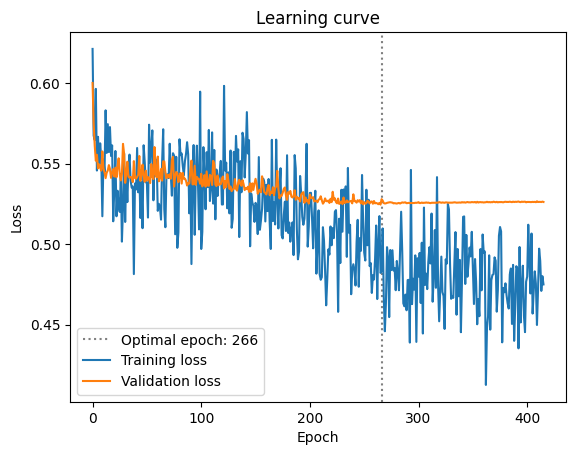

In [ ]:
intermediate_values = study.best_trial.intermediate_values

optimal_epochs = study.best_trial.user_attrs["epochs"]

losses = study.best_trial.user_attrs["train_loss"]
val_losses = list(intermediate_values.values())

plt.axvline(x=optimal_epochs, color='grey', linestyle=':', label=f"Optimal epoch: {optimal_epochs}")
show_history(losses, val_losses, len(val_losses)-1)

With our final model we find a ROC_AUC score of around 0.81 and we are happy with this performance. This notebook is for pedagogical purposes only so we leave it at that, but for a real project, one last step in a different script would be to test the model's real performance on a test set.